# 문서 특징
- ImageDataGenerator로 이미지 전처리
    - train 데이터 확보를 위해 평행이동, 좌우반전한 이미지도 generate해서 학습
    - https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/ 참고
- RGB 이미리로 학습
- 640,480 사이즈로 이미지 resize후 학습

- [폴더 구조]
> --- images
        --- train
            --- 0
            --- 1
        --- test
            --- 0
            --- 1

In [ ]:
# execute on colab
# from google.colab import drive
# drive.mount('/content/drive')
# % cd /content/drive/My Drive/supergate/Image_Detector/object_detection
# % ls

In [4]:
# 버전 확인
! pip list | grep tensor

tensorboard                        2.0.2
tensorflow                         2.0.0
tensorflow-estimator               2.0.1


You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
! ls ./images

01_line_detection.ipynb
02.img_model_generator.py
02_train.py
03_train.ipynb
04_train_total_img.ipynb
X_test.bin
Y_test.bin
images
make_img_f_list.py
make_labeled_dir.py
model
restore_img_folder.py


In [93]:
# 이미지 전처리
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range = 0.2,
        zoom_range=0.2,
        height_shift_range = 0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'images/train',
        target_size=(640, 480),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'images/test',
        target_size=(640, 480),
        batch_size=32,
        class_mode='binary')
# model.fit(
#         train_generator,
#         steps_per_epoch=2000,
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=800)

Found 258 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [94]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


In [95]:
# import os
import cv2
import numpy as np
import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd
import argparse
from sklearn.model_selection import train_test_split
import pickle


# 모델정의
model = Sequential()
#CNN-1
model.add(Conv2D(
    # input_shape=X.shape[1:],  #(640, 480, 3) ,color image
    input_shape=(150, 150,3),
    filters=128,
    kernel_size=(3,3),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(3, 3)))
#cnn-2
model.add(Conv2D(
    filters=64,
    kernel_size=(4,4),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.02))
#cnn-3
model.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(1,1),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.02))
model.add(Conv2D(32,kernel_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# fully-connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 75, 75, 128)       3584      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 13, 13, 64)        131136    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 6, 6, 32)          18464     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 3, 3, 32)        

In [96]:
#compile
model.compile(optimizer='adam',
loss = tf.keras.losses.BinaryCrossentropy(),
metrics= ['accuracy'],
)

#parameter
batch_size = 50
epochs = 30


In [97]:
history=model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator)

Train for 9 steps, validate for 4 steps
Epoch 1/30
9/9 [==============================] - 32s 4s/step - loss: 0.6948 - accuracy: 0.5155 - val_loss: 0.7022 - val_accuracy: 0.4107
Epoch 2/30
9/9 [==============================] - 34s 4s/step - loss: 0.6911 - accuracy: 0.5194 - val_loss: 0.6891 - val_accuracy: 0.5625
Epoch 3/30
9/9 [==============================] - 32s 4s/step - loss: 0.6852 - accuracy: 0.5426 - val_loss: 0.6670 - val_accuracy: 0.5714
Epoch 4/30
9/9 [==============================] - 33s 4s/step - loss: 0.6914 - accuracy: 0.5969 - val_loss: 0.6578 - val_accuracy: 0.6161
Epoch 5/30
9/9 [==============================] - 31s 3s/step - loss: 0.6823 - accuracy: 0.5775 - val_loss: 0.6751 - val_accuracy: 0.6161
Epoch 6/30
9/9 [==============================] - 31s 3s/step - loss: 0.6710 - accuracy: 0.6163 - val_loss: 0.6797 - val_accuracy: 0.5893
Epoch 7/30
9/9 [==============================] - 31s 3s/step - loss: 0.6794 - accuracy: 0.6240 - val_loss: 0.6633 - val_accuracy: 0

# Prediction

In [99]:
result_batch = model.predict(validation_generator)

In [113]:
validation_generator[0][1]

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [121]:
pd.DataFrame(zip(np.round(result_batch[:,0]),validation_generator[0][1]),columns=['prediction','true'])

,prediction,true
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0
5,1.0,1.0
6,0.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,0.0


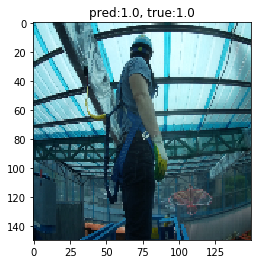

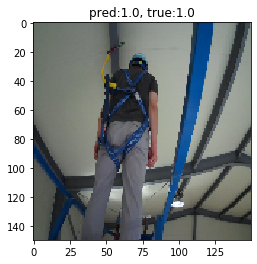

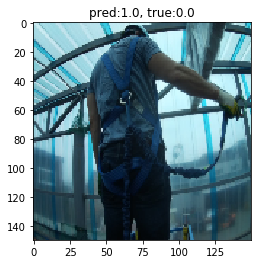

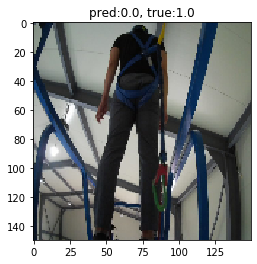

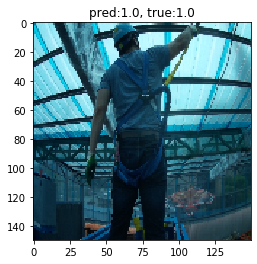

In [126]:
import matplotlib.pyplot as plt
idx =np.random.choice(len(validation_generator[0][0]),size=5, replace=False)
image_batch, labels_batch = validation_generator[0]
for i in idx:
    plt.figure()
    plt.imshow(image_batch[i])
    result = model.predict(np.expand_dims(image_batch[i],axis=0))[0,0]
    plt.title(f"pred:{round(result)}, true:{labels_batch[i]}")
    plt.show()


In [131]:
import os
test_loss, test_acc = model.evaluate(validation_generator,verbose=0)
print(f"validation loss:{test_loss}")
print(f"validation accuracy:{test_acc}")
# 모델 저장
model.save('./model/model_total_img.h5')

validation loss:0.6570543199777603
validation accuracy:0.6339285969734192


## Result
>  validation accuracy가 너무 낮음
- gray scale을 시도해보자
> https://keras.io/api/preprocessing/image/
- detect 한 정보만 추출해보자